<a href="https://colab.research.google.com/github/NataliaTarasovaNatoshir/NataliaTarasovaNatoshir/blob/main/Monty_Hall_z_stat_for_shares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Monty Hall Problem

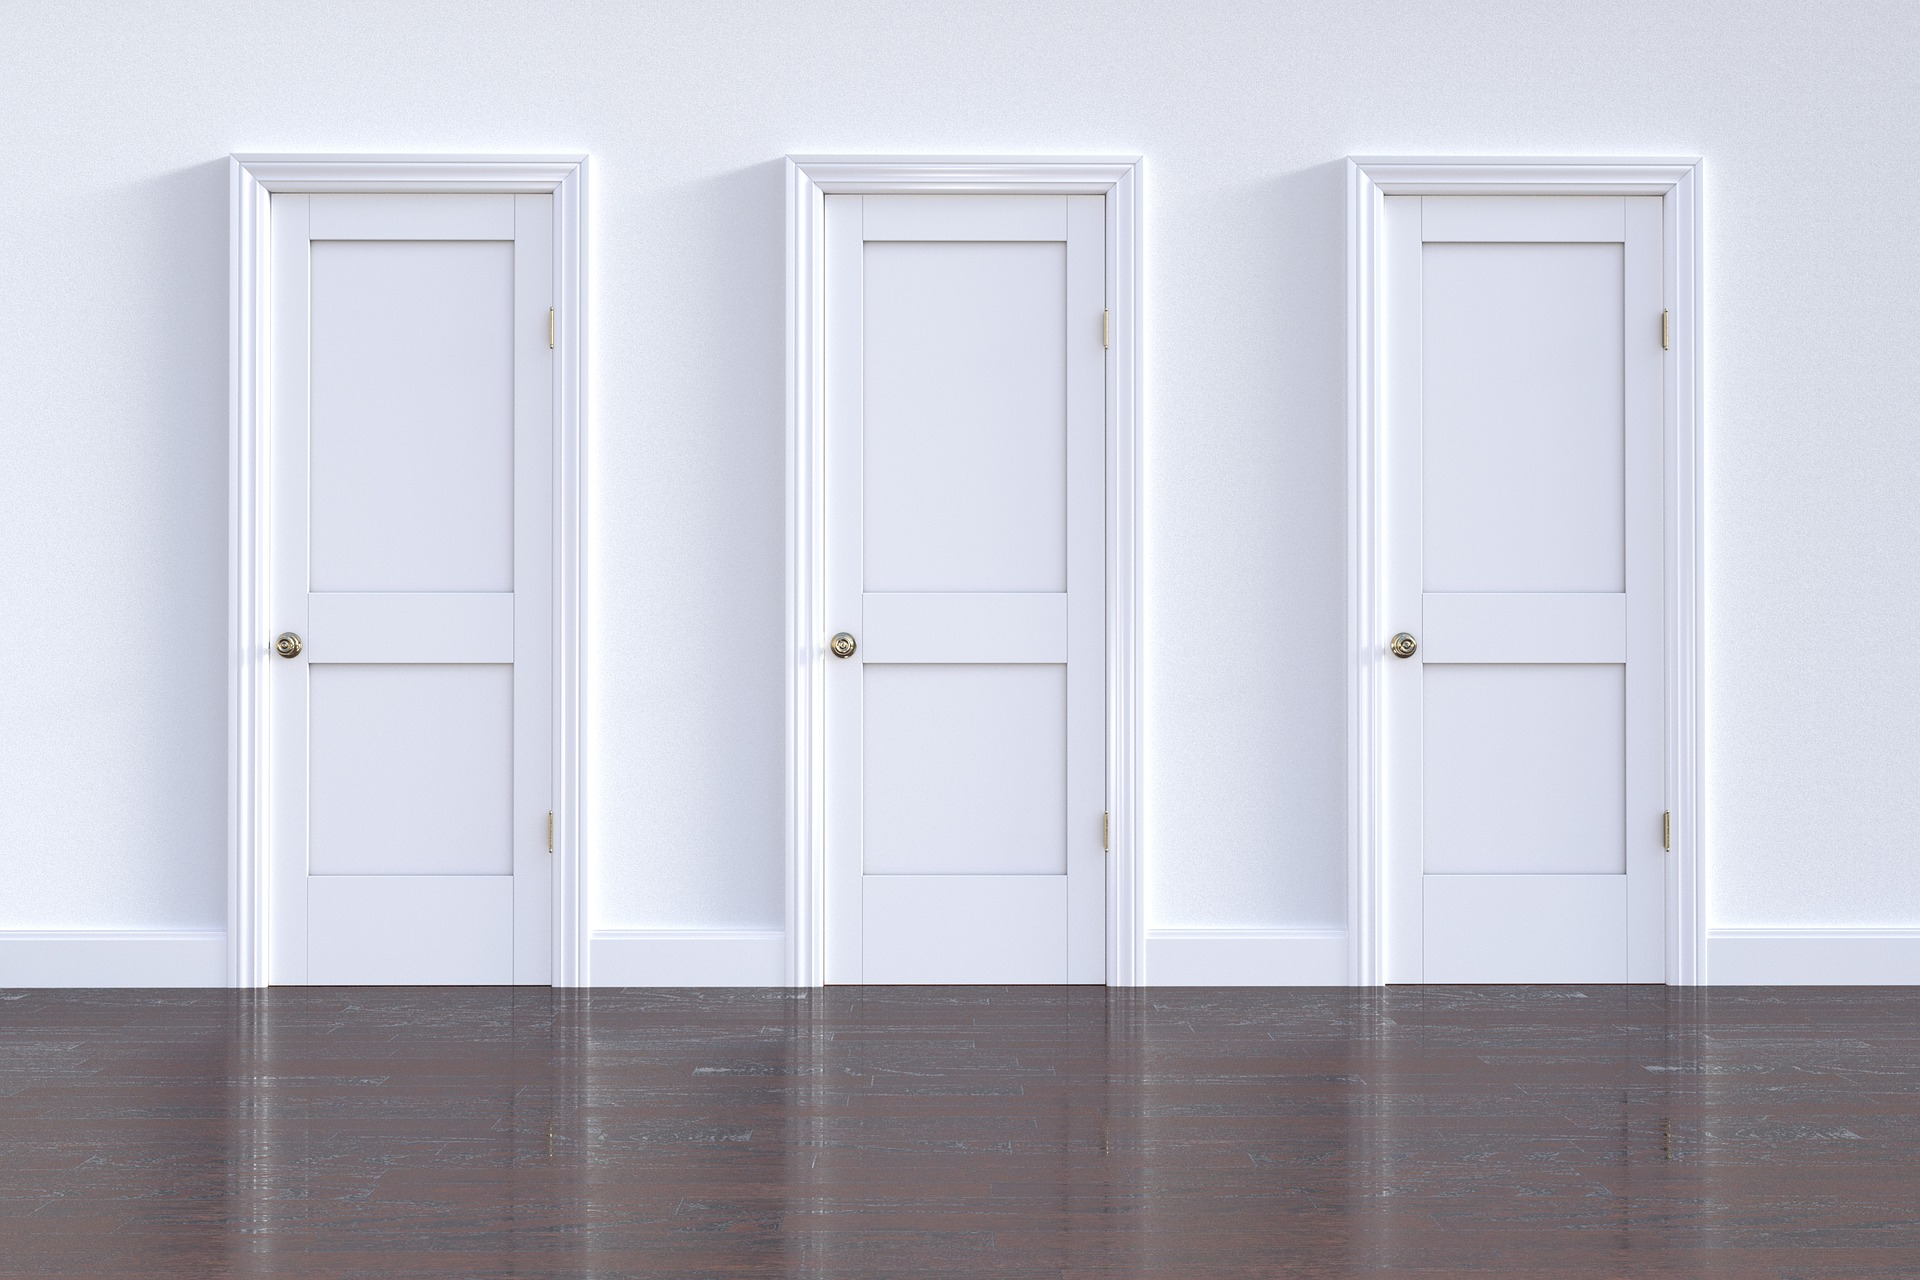


[The Monty Hall problem](https://en.wikipedia.org/wiki/Monty_Hall_problem) is a probability puzzle also known as "Three doors problem". It is famous for its counter-intuitive solution that may sound absurd but is nevertheless true.

> Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a car; behind the others, goats. You pick a door, say No. 1, and the host, who knows what's behind the doors, opens another door, say No. 3, which has a goat. He then says to you, "Do you want to pick door No. 2?" Is it to your advantage to switch your choice?



**This notebook has two goals:**


1.   Show the application of statistics for dealing with proportions in finite samples of 0s and 1s ([Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)) . Classic examples of this task include:

*   Define whether the new ads banner attracks more clicks than the old banner
*   Estimate the length of an A/B experiment required to provide a statistically significant conclusion
*   Check whether a sample with objects from two classes has a significally skewed class distribution


2.   Run numerical experiments to support the counter-intuitive solution of the Monty Hall problem



## Analytical Solution

The correct solution was described by [Steve Selvin](https://en.wikipedia.org/wiki/Steve_Selvin) in 1975. The answer is that the contestant should **switch to the other door.** 

The switching strategy has a 2/3 probability of winning the car, while the strategy that remains with the initial choice has only a 1/3 probability.

On of the ways to understand the solution is to consider the two original unchosen doors together. Cecil Adams puts it: "Monty is saying in effect: you can keep your one door or you can have the other two doors." The 2/3 chance of finding the car has not been changed by the opening of one of these doors because Monty, knowing the location of the car, is certain to reveal a goat. So the player's choice after the host opens a door is no different than if the host offered the player the option to switch from the original chosen door to the set of both remaining doors. The switch in this case clearly gives the player a 2/3 probability of choosing the car.

# Numerical Experiments

Let's see if it is possible to confirm the analytical solution with numerical experiments!

First we have to define a function that plays as a show host:


1.   Door with a car behind it is chosen randomly (door names are 0, 1 or 2)
2.   Passed "strategy" selects a door
2.   Host opens another door that has a goat behind it
2.   "Strategy" makes a final guess
2.   Host reveals wether this final guess was correct (returns 1) or wrong (returns 0)




In [2]:
def play_three_door_game(strategy, show_log=False):
  correct_door_pos = random.randint(0, 2)
  if show_log: print('Correct door: {}'.format(correct_door_pos))

  first_guess = strategy(first_guess=-1, empty_door_num=None)
  if show_log: print('First guess: {}'.format(first_guess))

  if first_guess != correct_door_pos:
    empty_door_num = {0, 1, 2} - {correct_door_pos} - {first_guess}
    empty_door_num = empty_door_num.pop()
  else:
    empty_door_num = random.choice(list({0, 1, 2} - {correct_door_pos}))
  if show_log: print('Showed empty door: {}'.format(empty_door_num))

  second_guess = strategy(first_guess=first_guess, empty_door_num=empty_door_num)
  if show_log: print('Second guess: {}'.format(second_guess))

  if second_guess == correct_door_pos:
    if show_log: print('Strategy won!')
    return 1
  else:
    if show_log: print('Strategy lost!')
    return 0

The first strategy we analyze is a "hold-door" strategy that does not change its first guess after another door is opened

In [3]:
def hold_strategy(first_guess=-1, empty_door_num=None):
  if first_guess >= 0:
    return first_guess
  else:
    return random.randint(0, 2)

Here's how the "hold-door" strategy plays a game:


In [6]:
play_three_door_game(strategy=hold_strategy, show_log=True)

Correct door: 0
First guess: 2
Showed empty door: 1
Second guess: 2
Strategy lost!


0

Another strategy is a "change-door" strategy that always changes its first guess after another door is opened

In [4]:
def change_strategy(first_guess=-1, empty_door_num=None):
  if first_guess >= 0:
    s = {0, 1, 2} - {first_guess} - {empty_door_num}
    return s.pop()
  else:
    return random.randint(0, 2)

Here's how the "change-door" strategy plays a game:

In [7]:
play_three_door_game(strategy=change_strategy, show_log=True)

Correct door: 2
First guess: 1
Showed empty door: 0
Second guess: 2
Strategy won!


1

A function to run a series of games using the same strategy:

In [5]:
def run_experiment_series(strategy, trials_num):
  res = []
  print('Started series of {} experiments'.format(trials_num))
  for i in range(trials_num):
    trial_res = play_three_door_game(strategy=strategy)
    res.append(trial_res)
  print('Experiment finished')
  print('{0} wins out of {1} trials. Success share = {2:.2f}%'.format(
      sum(res), len(res), 100 * sum(res) / len(res)))
  return res

## Confidence interval for the probability of winning

When we run a series of games we obtain a **sampled win share** for the strategy. This is only an estimation of the true win probability. We can define a confidence interval for this estimation with a fixed α-value. It means that the probability of the true win probability to be outside of this interval is less than α. The more games we play, the smaller is the confidence interval and the more precise is our estimation of the true win probability value

In [9]:
TRIALS_NUM = 10

In [10]:
res_change = run_experiment_series(strategy=change_strategy, trials_num=TRIALS_NUM)

Started series of 10 experiments
Experiment finished
6 wins out of 10 trials. Success share = 60.00%


One of the effective ways to calculate binomial proportion confidence intervals is the [Wilson score](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) method.

Let's use the Wilson score method for the "change-door"-strategy

In [11]:
conf_interval_change = proportion_confint(sum(res_change), len(res_change), 
                                          method = 'wilson')

print("Change door strategy:\n95% confidence interval for win probability = [{0:.2f}, {1:.2f}]".format(
    conf_interval_change[0], conf_interval_change[1]))

Change door strategy:
95% confidence interval for win probability = [0.31, 0.83]


Two strategies that we compare ("hold door"-strategy and "change door"-strategy) are mutually exclusive. It means that in a situation where one strategy loses the game, another strategy - wins the game. If we want to support a hypothesis that the "change door"-strategy is better than the "hold door"-strategy, we need to compare the win probability of the "change door"-strategy with a value of 0.5.

Note that in the sample above while proportion of wins for the "change door"-strategy is more than 50% - confidence interval includes 0.5 value. 10 games for this strategy is not enough to conclude that the "change door"-strategy is better than an alternative "hold-door" strategy

## Z-statistics for a probability score

It may sound reasonable that when a host opens a door with the goat behind it, we have two doors (one has a car behind it, another - a goat) so the probability to guess the correct door is simply 0.5.

Let's apply a statistic criteria to compare the sampled win share for the "change-door" strategy with a fixed probability of 0.5

 If $X_1$ are independent samples from Bernoulli distribution, where there are a "wins" and c "losses":


  | | $X_1$ | | 
  ------------- | -------------||
  1  | a |
  0  | c |
  $\sum$ | $n$|

Then
  
$$ \hat{p} = \frac{a}{n} - \text{sample share}$$
$$ {p_0} - \text{fixed probability}$$

$$ {H_0}: {p} = {p_0} - \text{null hypothesis}$$
$$ {H_1}: {p} <\neq> {p_0} - \text{alternative hypothesis}$$

$$\text{Z-criteria: } Z({X_1}) =  \frac{\hat{p} - {p_0}}{\sqrt{\frac{{p_0}(1 - {p_0})}{n} }}$$

$$\text{Confidence interval for }p\colon \;\; {p_0} \pm z_{1-\frac{\alpha}{2}}{\sqrt{\frac{{p_0}(1 - {p_0})}{n} }}$$

In [6]:
def share_z_stat(sample, p_0):
    n = len(sample)
    p = float(sum(sample)) / n
    
    return (p - p_0) / np.sqrt((p_0 * (1 - p_0)) / n)

In [7]:
def share_p_value(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("Invalid alternative\n"
                         "Possible options: 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [8]:
def shares_diff_confint_ind(sample, p_0, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p = float(sum(sample)) / len(sample)
    
    left_boundary = p_0 - z * np.sqrt(p_0 * (1 - p_0)/ len(sample))
    right_boundary = p_0 + z * np.sqrt(p_0 * (1 - p_0)/ len(sample))
    
    return (left_boundary, right_boundary)

In [25]:
TRIALS_NUM_05 = 50
res_change_new = run_experiment_series(strategy=change_strategy, trials_num=TRIALS_NUM_05)

z_stat = share_z_stat(res_change_new, p_0=0.5)
print("\nZ-statistics = {0:.2f}\n".format(z_stat))

print('H_0 hypothesis: Win probability = 0.5\n')

print('H_1 hypothesis: Win probability != 0.5')
p_value_two_sided = share_p_value(z_stat=z_stat, alternative = 'two-sided')
print("p-value for two-sided test = {0:.4f}".format(p_value_two_sided))
print("Meaning: possibility to obtain in an experiment this sample win share \
while true win probability = 0.5 is equal to {0:.2f}%\n".format(100 * p_value_two_sided))

print("Use the suggestion that 'change door'-strategy is more effective than 0.5")
print('H_1 hypothesis: Win probability > 0.5')
p_value_hold_greater = share_p_value(z_stat=z_stat, alternative = 'greater')
print("p-value for right-sided test = {0:.4f}".format(p_value_hold_greater))
print("Meaning: possibility to obtain in an experiment this or greater win share \
while true win probability = 0.5 is less than {0:.2f}%".format(100 * p_value_hold_greater))

Started series of 50 experiments
Experiment finished
31 wins out of 50 trials. Success share = 62.00%

Z-statistics = 1.70

H_0 hypothesis: Win probability = 0.5

H_1 hypothesis: Win probability != 0.5
p-value for two-sided test = 0.0897
Meaning: possibility to obtain in an experiment this sample win share while true win probability = 0.5 is equal to 8.97%

Use the suggestion that 'change door'-strategy is more effective than 0.5
H_1 hypothesis: Win probability > 0.5
p-value for right-sided test = 0.0448
Meaning: possibility to obtain in an experiment this or greater win share while true win probability = 0.5 is less than 4.48%


### Evaluate the length of an A/B test

It is a frequent situation when before A/B testing we need an estimation of how long this test should be. In our case the question is: "How many games should be played before we can say that "change door"-strategy has win probability higher than 0.5?" 

For example we may proceed as follows:


1.   Using our assumption about the true win probability for this strategy, calculate confidence interval with a selected number of games N
2.   Imagine that we got "the worst case scenario" - we have the left edge of the confidence interval as a sample win probability estimation
2.   Estimate p-value for ${H_1}$ hypothesis with "the worst case scenario" sample win share
2.   Check that estimated p-value is lower than the goal p-value, that means that the proposed number of games N is sufficient


In [9]:
def get_conf_interval_edge(p_true, N, conf_interval_alpha=0.05):
  conf_interval_p = proportion_confint(int(p_true*N), N, method = 'wilson', 
                                        alpha=conf_interval_alpha)
  return conf_interval_p[0]

def z_stat_expected(p, p_0, N):
  return (p - p_0) / np.sqrt((p_0 * (1 - p_0)) / N)

def estimate_p_value(p_true, p_0, N, alternative = 'two-sided', p_value_goal=0.05):
  p = get_conf_interval_edge(p_true, N)
  if p <= p_0:
    print('Confidence interval includes {}. Try a bigger number of trials'.format(p_0))
    return 0
  else:
    print('Using the worst case scenario:\n\
    p = {0:.2f}\n'.format(p))
  z_stat = z_stat_expected(p, p_0, N)
  estimated_p_value = share_p_value(z_stat, alternative = alternative)
  print("Estimated p-value for {0} trials = {1:.4f}".format(
      N, estimated_p_value))
  if p_value_goal < estimated_p_value:
    print("Goal p-value {0:.4f} is smaller that estimated p-value {1:.4f}".format(
        p_value_goal, estimated_p_value))
    print('Try a bigger number of trials')
  else:
    print("Goal p-value {0:.4f} is greater that estimated p-value {1:.4f}".format(
        p_value_goal, estimated_p_value))
    print('Number of trials should be enough to test the hypothesis that win probability is higher than 1/2')

In [30]:
estimate_p_value(p_true=2/3, p_0=1/2, N=10, alternative = 'two-sided', 
                 p_value_goal=0.05)

Confidence interval includes 0.5. Try a bigger number of trials


0

In [33]:
estimate_p_value(p_true=2/3, p_0=1/2, N=50, alternative = 'two-sided', 
                 p_value_goal=0.05)

Using the worst case scenario:
    p = 0.52

Estimated p-value for 50 trials = 0.7607
Goal p-value 0.0500 is smaller that estimated p-value 0.7607
Try a bigger number of trials


In [37]:
estimate_p_value(p_true=2/3, p_0=1/2, N=150, alternative = 'two-sided', 
                 p_value_goal=0.05)

Using the worst case scenario:
    p = 0.59

Estimated p-value for 150 trials = 0.0313
Goal p-value 0.0500 is greater that estimated p-value 0.0313
Number of trials should be enough to test the hypothesis that win probability is higher than 1/2


Let's run an experiment with N chosen above

In [81]:
res_change_new = run_experiment_series(strategy=change_strategy, trials_num=150)
p_0 = 0.5
print("\nExperiments result:")
z_stat = share_z_stat(res_change_new, p_0=p_0)
print("Z-statistics for win share compared with {0} = {1:.2f}\n".format(
    p_0, z_stat))

p_value_two_sided = share_p_value(z_stat=z_stat, alternative = 'two-sided')

print("p-value for two-sided test = {0:.4f}".format(p_value_two_sided))
print("Meaning: possibility to obtain in an experiment this or greater absolute win share \
(while true win probability = {0}) equals {1:.2f}%\n".format(p_0, 100 * p_value_two_sided))

Started series of 150 experiments
Experiment finished
90 wins out of 150 trials. Success share = 60.00%

Experiments result:
Z-statistics for win share compared with 0.5 = 2.45

p-value for two-sided test = 0.0143
Meaning: possibility to obtain in an experiment this or greater absolute win share (while true win probability = 0.5) equals 1.43%



## Evaluate the strategy win probability

So, can we precisely estimate the probability to win for a chosen strategy?

What we can do is to get enough samples in order to have a confidence interval as small as we deem sufficient

The Wilson score interval is the most wide when we obtain sample share = 0.5 (see the figure below)

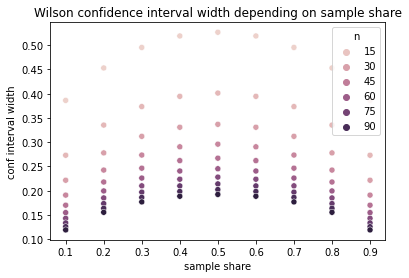

In [45]:
x = np.arange(0.1, 1, 0.1)
n = 10
y = [proportion_confint(int(p*n), n, method = 'wilson') for p in x]
df = pd.DataFrame({"sample share": x, 
                   "conf interval width": [y_[1] - y_[0] for y_ in y], "n": [n]*len(x)})
for n in range(20, 110, 10):
  y = [proportion_confint(int(p*n), n, method = 'wilson') for p in x]
  df_ = pd.DataFrame({"sample share": x, 
                   "conf interval width": [y_[1] - y_[0] for y_ in y], "n": [n]*len(x)})
  df = df.append(df_)

sns.scatterplot(data=df, x="sample share", y="conf interval width", hue='n')
plt.title('Wilson confidence interval width depending on sample share')
plt.show()

It means that we can first define number samples N that we need to get the confidence interval smaller than the chosen threshold

In [10]:
def max_wilson_conf_interval_width(N, alpha=0.05):
  conf_interval = proportion_confint(int(0.5*N), N, method = 'wilson', alpha=alpha)
  return conf_interval[1] - conf_interval[0]

def estimate_wilson_conf_interval(N, goal_width=0.2, alpha=0.05):
  max_width = max_wilson_conf_interval_width(N, alpha=alpha)
  print("Maximum Wilson score interval width for N={0} is {1:.2f}".format(N, max_width))
  if max_width > goal_width:
    print("Wilson score interval may be wider than goal width {}\nTry a bigger N".format(goal_width))
  else:
    print("Wilson score interval is smaller than goal width {}\nN is sufficient".format(goal_width))

In [47]:
estimate_wilson_conf_interval(N=100, goal_width=0.1, alpha=0.05)

Maximum Wilson score interval width for N=100 is 0.19
Wilson score interval may be wider than goal width 0.1
Try a bigger N


In [48]:
estimate_wilson_conf_interval(N=400, goal_width=0.1, alpha=0.05)

Maximum Wilson score interval width for N=400 is 0.10
Wilson score interval is smaller than goal width 0.1
N is sufficient


For example, N=400 seems to be enough to get the confidence interval smaller than 0.1

Let's run a series of trials for the "change-door"-strategy:

In [49]:
TRIALS_NUM = 400
res_change_new = run_experiment_series(strategy=change_strategy, trials_num=TRIALS_NUM)

conf_interval_change = proportion_confint(sum(res_change_new), len(res_change_new), 
                                          method = 'wilson')
print()

print("Change door strategy:\n95% confident interval for win probability = [{0:.2f}, {1:.2f}]".format(
    conf_interval_change[0], conf_interval_change[1]))
print('Interval width = {0:.2f}'.format(conf_interval_change[1] - conf_interval_change[0]))

Started series of 400 experiments
Experiment finished
279 wins out of 400 trials. Success share = 69.75%

Change door strategy:
95% confident interval for win probability = [0.65, 0.74]
Interval width = 0.09


## Z-statistics for difference in shares

The "change door"-strategy and the "hold door"-strategy are mutually exclusive: when one strategy loses it means that another one wins. In this case to compare these strategies it is enough to compare one of these strategies win probability with 0.5.

But what if we have two different independent strategies? How to check if two strategies have different win probabilities? We can use Z-criteria for independent samples: 

 If $X_1$ and $X_2$ are independent samples described here:


  | | $X_1$ | $X_2$  | 
  ------------- | -------------| -------------|
  1  | a | b |
  0  | c | d |
  $\sum$ | $n_1$| $n_2$

Than
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Confidence interval for }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-criteria: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

Consider another strategy that holds onto its initial guess or change its mind randomly (with equal probabilities):

In [11]:
def random_switch_strategy(first_guess=-1, empty_door_num=None):
  if first_guess >= 0:
    s = random.choice(list({0, 1, 2} - {empty_door_num}))
    return s
  else:
    return random.randint(0, 2)

Here's how it plays the game:

In [13]:
play_three_door_game(strategy=random_switch_strategy, show_log=True)

Correct door: 1
First guess: 0
Showed empty door: 2
Second guess: 0
Strategy lost!


0

In [14]:
def shares_diff_z_stat(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [15]:
def shares_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [32]:
TRIALS_NUM = 100

# run two independent series of experiments
res_random_switch = run_experiment_series(strategy=random_switch_strategy, 
                                          trials_num=TRIALS_NUM)
res_change = run_experiment_series(strategy=change_strategy, 
                                       trials_num=TRIALS_NUM)
print()

# print sample statistics
print("Number of trials for each strategy: {}\n".format(TRIALS_NUM))
print("Random switch win share = {0:.2f}%\nChange strategy win share = {1:.2f}%".format(
    100 * sum(res_random_switch) / TRIALS_NUM, 100 * sum(res_change) / TRIALS_NUM))
print("Win shares difference = {0:.2f}".format(
    ((sum(res_random_switch) - sum(res_change)) / TRIALS_NUM)))

# 95% confidence interval for the difference in win shares
strategies_diff_confint = shares_diff_confint_ind(res_random_switch, res_change)
print("95% confident interval for strategies win probability difference = [{0:.2f}, {1:.2f}]".format(*strategies_diff_confint))

# Z-statistics for the difference in win shares
z_stat_startegies_diff = shares_diff_z_stat(res_random_switch, res_change)
print("Z-statistics for win shares difference = {0:.2f}\n".format(z_stat_startegies_diff))

# p value for two-sided test. We do not make a suggestion which strategy is better
p_value_two_sided = share_p_value(z_stat=z_stat_startegies_diff, 
                                        alternative = 'two-sided')
print("p-value for two-sided test = {0:.4f}".format(p_value_two_sided))
print("Meaning: possibility to obtain in an experiment this or greater absolute difference in win shares \
while true win probabilities are equal is less than {0:.2f}%\n".format(100 * p_value_two_sided))

# p value for one-sided test. We make a suggestion that the second strategy is better
print("Use the suggestion that 'change door'-strategy is more effective than 'random switch'-strategy")
p_value_less = share_p_value(z_stat=z_stat_startegies_diff, 
                                        alternative = 'less')
print("p-value for left-sided test = {0:.4f}".format(p_value_less))
print("Meaning: possibility to obtain in an experiment this or more negative difference in win shares \
while true win probabilities are equal is less than {0:.2f}%".format(100 * p_value_less))

Started series of 100 experiments
Experiment finished
44 wins out of 100 trials. Success share = 44.00%
Started series of 100 experiments
Experiment finished
60 wins out of 100 trials. Success share = 60.00%

Number of trials for each strategy: 100

Random switch win share = 44.00%
Change strategy win share = 60.00%
Win shares difference = -0.16
95% confident interval for strategies win probability difference = [-0.30, -0.02]
Z-statistics for win shares difference = -2.26

p-value for two-sided test = 0.0235
Meaning: possibility to obtain in an experiment this or greater absolute difference in win shares while true win probabilities are equal is less than 2.35%

Use the suggestion that 'change door'-strategy is more effective than 'random switch'-strategy
p-value for left-sided test = 0.0118
Meaning: possibility to obtain in an experiment this or more negative difference in win shares while true win probabilities are equal is less than 1.18%


This test shows that the "change door"-strategy is statistically significantly more effective that the "random switch"-strategy. Note that statistical significance is not guaranteed for this test length.

# Conclusion

To support the counter-intuitive analytical solution for the Monty Hall problem we have successfully used:

1.   Numerical experiments to simulate long series of games for different strategies
2.   Statistical apparatus to evaluate the statistical significance of these findings
2.   Looked into related tasks like

  *   A/B-test length estimation to reach statistical significance
  *   Statistical criteria to compare shares in independent samples of zeroes and ones








